In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import math

In [2]:
def ExactSolution(x,y):
    # y^2*sin(pi*x)
    return torch.sin(np.pi*x)*y**2

In [3]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1])
    
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1)
    
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    
    return grid_x, grid_y, data_matrix

/Users/junaidaftab/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[0.0357, 0.0357],
        [0.0357, 0.0714],
        [0.0357, 0.1071],
        ...,
        [0.9643, 0.8929],
        [0.9643, 0.9286],
        [0.9643, 0.9643]], requires_grad=True)

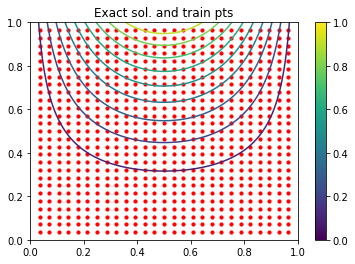

In [4]:
# define training points
npt1 =  29
strip_boundary = True
xtrain_grid, ytrain_grid, train_data = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))  
plt.scatter(train_data[:,0],train_data[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")

train_data.requires_grad_(True)

In [5]:
class NN(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)
        
        
    def forward(self, xb):
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = torch.tanh(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    
def SolutionModel(x, y, model):
    '''
    Compute the approximate solution to the problem based on the known
    boundary conditions and the neural network approximation in the domain.

    Nx is the number of mesh points in the x direction, similarly for Ny.

    Arguments
    ---------
    x: input tensor of shape (Nx * Ny,)
    y: input tensor of shape (Nx * Ny,)
    model: an object extending torch.nn.Module

    Returns
    -------
    solution: output tensor of shape (Nx * Ny, 1)
    '''

    # create tensor of size (Nx * Ny, 1) of ones for top (x, 1) boundary 
    ones = torch.ones_like(y[:, None])
    ones.requires_grad = True

    # calculate the value of the top Neumann boundary condition
    top_boundary_value = 2 * torch.sin(np.pi * x)

    # compute the solution model term which incorporates boundary conditions
    boundary_term = y * top_boundary_value

    # compute N(x, y, p)
    domain_input_data = torch.cat((x[:, None], y[:, None]), axis=1)
    nn_domain_output = model(domain_input_data)[:, 0]

    # compute N(x, 1, p)
    boundary_input_data = torch.cat((x[:, None], ones), axis=1)
    nn_boundary_output = model(boundary_input_data)[:, 0]

    # compute dN(x, y, p)/dy at y = ones
    nn_y_derivative = torch.autograd.grad(outputs=nn_boundary_output,
                                          inputs=ones,
                                          allow_unused=True,
                                          grad_outputs=torch.ones_like(nn_boundary_output),
                                          retain_graph=True,
                                          create_graph=True)[0][:, 0]

    # compute entire domain term
    domain_term = x * (1 - x) * y * (nn_domain_output +
                                     - nn_boundary_output + 
                                     - nn_y_derivative)
    
    # print(boundary_term.shape)
    # print(nn_domain_output.shape)
    
    solution = boundary_term + domain_term

    return(solution[:, None])

def RHS(x,y):
    #return (2 - pi**2*y**2)*sin(pi*x)
    return (2-np.pi**2*y**2)*torch.sin(np.pi*x)

In [6]:
N_neuron = 10
input_size = 2
output_size = 1

model = NN(input_size,N_neuron,output_size)

In [7]:
#prepare training data
size1,size2 = train_data.shape
rhs = torch.zeros(size1,)
train_ds = TensorDataset(train_data,rhs)

batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [8]:
Loss = []
n = 2000
iteration_nums = np.arange(0,n)

for epoch in range(n):
    TOL = 1.0e-8
    for X,y in train_dl:
        optimizer.zero_grad()
        Q = SolutionModel(X[:,0],X[:,1],model)
        
        derivQ = torch.autograd.grad(Q,X,allow_unused=True, retain_graph=True, grad_outputs = torch.ones_like(Q), create_graph=True)
        dQ = derivQ[0]
        
        deriv_xx_xy = torch.autograd.grad(dQ[:,0], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,0]), \
        retain_graph=True, create_graph=True)
        
        deriv_yx_yy = torch.autograd.grad(dQ[:,1], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,1]), \
        retain_graph=True, create_graph=True)
        
        Qyy = deriv_yx_yy[0][:,1]
        Qxx = deriv_xx_xy[0][:,0]
        
        lhs = Qxx+Qyy - RHS(X[:,0],X[:,1])
        
        loss = loss_fn(lhs,y)
        loss.backward()
        optimizer.step()
        
    Loss.append(loss.item())
    
    if epoch % 100 == 1:
        print('loss at epoch {} is {}'.format(epoch,loss))
    if loss < TOL:
        break

loss at epoch 1 is 38.322608947753906
loss at epoch 101 is 0.048889774829149246
loss at epoch 201 is 0.032901301980018616
loss at epoch 301 is 0.02285282500088215
loss at epoch 401 is 0.014026041142642498
loss at epoch 501 is 0.008489931002259254
loss at epoch 601 is 0.009365268982946873
loss at epoch 701 is 0.004646896384656429
loss at epoch 801 is 0.005462421104311943
loss at epoch 901 is 0.003880689851939678
loss at epoch 1001 is 0.0034175748005509377
loss at epoch 1101 is 0.003066570498049259
loss at epoch 1201 is 0.002339222701266408
loss at epoch 1301 is 0.0023213715758174658
loss at epoch 1401 is 0.0018283739918842912
loss at epoch 1501 is 0.001346769742667675
loss at epoch 1601 is 0.001239187316969037
loss at epoch 1701 is 0.0010996840428560972
loss at epoch 1801 is 0.00023352402786258608
loss at epoch 1901 is 9.367513848701492e-05


Max error =  0.0013350248
Mean error =  0.0004537694
RMS error =  0.00057558966


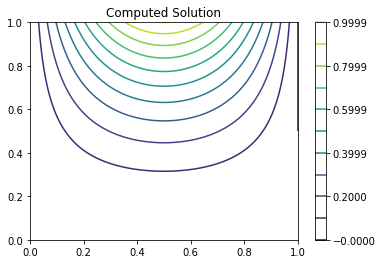

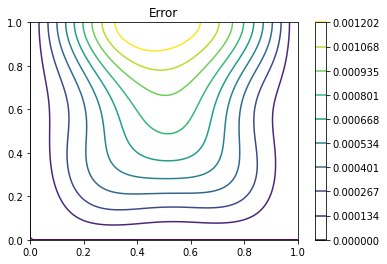

In [9]:
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)

for i in range(npt2):
    for j in range(npt2):
        
        pt = torch.tensor([xtest_grid[i,j],ytest_grid[i,j]])
        sol_test[i,j] = SolutionModel(xtest_grid[i,j].reshape(1),ytest_grid[i,j].reshape(1),model)

plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test.detach().numpy(),torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact).detach().numpy()
error_vector = np.reshape(error,(Ntest,1))
error_max = np.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,np.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",np.max(error_vector))
print("Mean error = ",np.mean(error_vector))
print("RMS error = ",np.sqrt(np.mean(error_vector**2)))

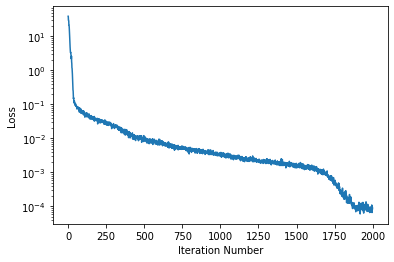

In [10]:
# Plot the loss function versus iteration number
plt.plot(iteration_nums, Loss)

# Set the y-axis scale to log
plt.yscale('log')

# Set the x- and y-axis labels
plt.xlabel('Iteration Number')
plt.ylabel('Loss')

# Show the plot
plt.show()